## `Speculator`: NMF-based SFH with burst.

`speculator` takes physical parameters and predict PCA coeffs (see `PCA_components_NMF.ipynb`), spectra, and also magnitudes. 

This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import os
os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
import torch
from torch import Tensor
from scipy.stats import norm

In [3]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator

In [4]:
# kuaizi: under master branch
import kuaizi
kuaizi.set_matplotlib(style='JL', usetex=True)

Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index

(10 params)

### Validate combined emulators

In [5]:
params = np.load(f'./train_sed_NMF/nmf_seds/fsps.NMF.v0.2.theta_unt.seedtest.npy')[:10000]
params = params[:, 1:]
# exclude stellar mass (1 M_\dot), remain redshift (i.e., length of SFH)
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
print('Number of samples:', params.shape[0])

Number of samples: 10000


In [6]:
# slow
fspecs = [f'./train_sed_NMF/nmf_seds/fsps.NMF.v0.2.log10spectrum.seedtest.npy']
logspec = np.load(fspecs[0])[:10000]
logspec = logspec.astype('float32')
logspec = logspec#[:, wave > 2000]

# wave = wave[wave > 2000]

In [7]:
from popsed.speculator import SuperSpeculator

In [8]:
superspec = SuperSpeculator(
    speculators_dir=[f'./speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'], 
    wavelength=wave)

In [9]:
_specs = superspec.predict_spec(params,
                                log_stellar_mass=None, 
                                redshift=None).cpu().detach().numpy()

In [10]:
diff = 100 * (10**logspec - _specs) / 10**logspec

In [11]:
med_diff = np.nanmedian(diff, axis=0)
diff_1sigma = [np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(1) * 100, axis=0)]
diff_2sigma = [np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(2) * 100, axis=0)]

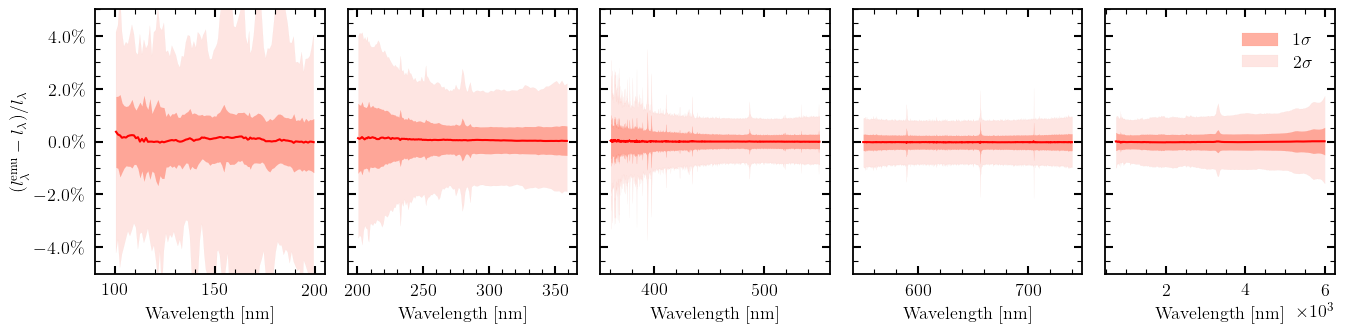

In [14]:
import matplotlib.ticker as mtick
fig, axes = plt.subplots(1, 5, figsize=(16, 3.5), sharey=True)

for i_bin in range(5):
    plt.sca(axes[i_bin])
    wave_bin = [ 
            (wave >= 1000) & (wave < 2000), 
            (wave >= 2000) & (wave < 3600), 
            (wave >= 3600) & (wave < 5500), 
            (wave >= 5500) & (wave < 7410), 
            (wave >= 7410) & (wave < 60000)
            ][i_bin]
    x = wave[wave_bin] / 10
    plt.plot(x, med_diff[wave_bin], color='r')
    plt.fill_between(x, 
                     diff_1sigma[0][wave_bin], 
                     diff_1sigma[1][wave_bin], 
                     alpha=0.5, lw=0.1, color='tomato', label='$1\sigma$')

    plt.fill_between(x, 
                     diff_2sigma[0][wave_bin], 
                     diff_2sigma[1][wave_bin], 
                     alpha=0.2, lw=0.1, color='salmon', label='$2\sigma$')
    plt.xlabel('Wavelength [nm]')
#     plt.ylim(-2.5, 2.5)
    plt.ylim(-5, 5)
    
axes[0].set_ylabel(r'$(l_{\lambda}^{\mathrm{emu}} - l_{\lambda})/l_{\lambda}$')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[-1].legend(loc='upper right')#, bbox_to_anchor=(-0.03, 1.))
axes[0].set_xlim(90, 205)

plt.savefig('/home/jiaxuanl/Research/popsed/figure/emulator_accuracy.png')

### Test magnitude

In [322]:
superspec = SuperSpeculator(
    speculators_dir=[f'./speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'], 
    wavelength=wave)

In [323]:
_mags = superspec.predict_mag(params,
                              log_stellar_mass=None, 
                              redshift=None, 
                              filterset=[f'sdss_{ff}0' for ff in 'ugriz']
                             ).cpu().detach().numpy()

In [324]:
# Use sedpy to calculate magnitudes on true spectra
from sedpy import observate
from popsed.models import lightspeed, to_cgs_at_10pc, jansky_cgs

In [325]:
filterset = observate.load_filters([f'sdss_{ff}0' for ff in 'ugriz'])
mags = np.zeros_like(_mags)
for i, f in enumerate(filterset):
    mags[:, i] = f.ab_mag(wave, 10**logspec * lightspeed / wave**2 * to_cgs_at_10pc)

In [326]:
diff = 100 * (mags - _mags) / mags

In [327]:
med_diff = np.nanmedian(diff, axis=0)
diff_1sigma = [np.nanpercentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(1) * 100, axis=0)]
diff_2sigma = [np.nanpercentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
               np.nanpercentile(diff, norm.cdf(2) * 100, axis=0)]

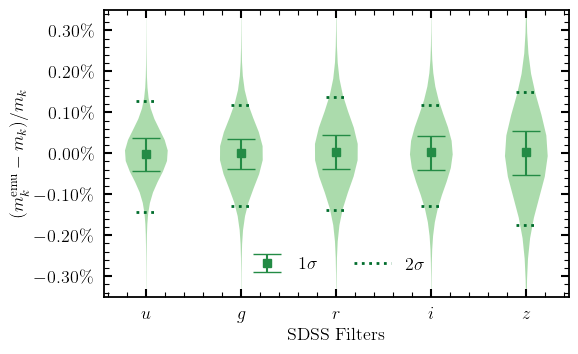

In [328]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots(figsize=(6, 3.8))

x = np.array([0, 1, 2, 3, 4])

plt.errorbar(x, med_diff, 
             yerr=[med_diff - diff_1sigma[0], 
                   diff_1sigma[1] - med_diff], 
             fmt='s', color='#238b45', capsize=10,
             label=r'$1\sigma$')
        
violin = plt.violinplot(diff, positions=x, 
                        showmedians=False, showextrema=False, 
                        quantiles=[[(1 - norm.cdf(2)), norm.cdf(2)] for i in range(5)],
                        widths=0.45,
                        points=1000
                       )
for pc in violin['bodies']:
    pc.set_facecolor('#74c476')
    pc.set_alpha(0.6)
violin['cquantiles'].set_color('#006d2c')
violin['cquantiles'].set_alpha(1.)
violin['cquantiles'].set_linestyle('dotted')
violin['cquantiles'].set_linewidth(2)
violin['cquantiles'].set_label(r'$2\sigma$')


ax.set_xticks(x)
ax.set_xticklabels([f'${ff}$' for ff in list('ugriz')])
ax.set_xlabel('SDSS Filters')
ax.set_ylabel(r'$(m_k^{\mathrm{emu}} - m_k) / m_k$')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='upper left', bbox_to_anchor=(-0.03, 1.))

plt.ylim(-0.35, 0.35)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]

plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
           loc='lower center', ncol=2, frameon=False, 
           facecolor=None, shadow=False) 

plt.savefig('/home/jiaxuanl/Research/popsed/figure/photulator_accuracy.png')

#### Try redshift

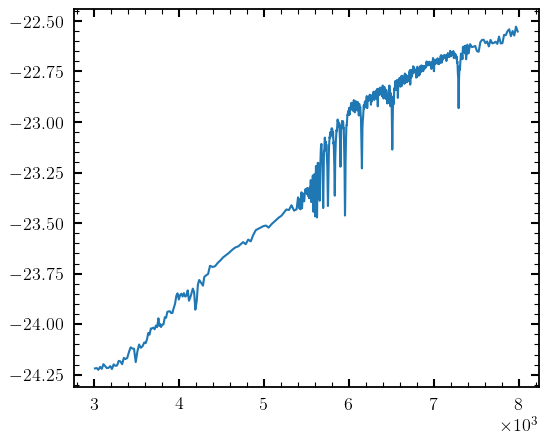

In [83]:
redshift_specs = torch.log10(superspec.predict_spec(params, 
                       log_stellar_mass=torch.ones(len(params), 1).to('cuda') * 10, 
                       redshift=torch.ones(len(params), 1).to('cuda') * 0.5))
flag = (superspec.wavelength < 8000) & (superspec.wavelength > 3000)
redshift_specs = redshift_specs[:, flag].cpu().detach().numpy()
plt.plot(superspec.wavelength[flag].cpu().numpy(), redshift_specs[5])